<a href="https://colab.research.google.com/github/redom69/Programa-de-deteccion-de-pizzarras/blob/main/Programa_de_deteccion_de_pizzarras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import math
from collections.abc import Iterable

#Imports necesarios

In [2]:
estructura = []  
FLANN_INDEX_LSH = 6
index_params= dict(algorithm = FLANN_INDEX_LSH,table_number = 6,key_size = 12, multi_probe_level = 1) 
search_params = dict(checks=100) # Número máximo de hojas a visitar cuando se busca vecinos
flann = cv.FlannBasedMatcher(index_params,search_params)
descriptores = []
keypoint = []
diccionario = {}
diccContours = {}

#Inicializa todos los valores necesarios

In [3]:
def rellenarEstructura(kp,estructura):
  contkp = 0
  for keyPoint in kp:
    x = keyPoint.pt[0]
    y = keyPoint.pt[1]
    s = keyPoint.size
    angulo1 = keyPoint.angle
    xB= (w/2) - x
    yB =(h/2) - y
    modulo = math.sqrt((xB*xB)+(yB*yB))
    if(yB==0):
      angulo = np.arctan(xB/0.01)
    else:
      angulo = np.arctan(xB/yB)
    estructura.append([des[contkp],s,angulo1,modulo,angulo]) #list[list float float float float]
    plt.plot(x,y, marker="o", color="red")
    contkp = contkp + 1
#Funcion para ordenar los keypoints en un diccionario

In [4]:
def filtradoImagen(img):
  dst = cv.fastNlMeansDenoisingColored(img,20,20,7,21) #Reducimos el ruido de la foto para que solo se vea casi el marco y poco mas
  filtered_image = cv.Canny(dst,50,500) 
  ret, thresh = cv.threshold(filtered_image, 127, 255, 0)
  contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

  return thresh

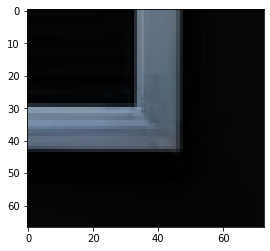

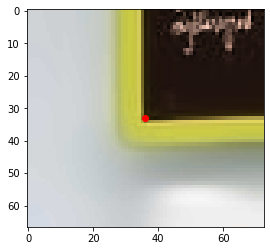

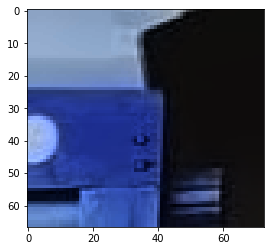

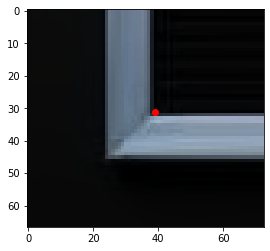

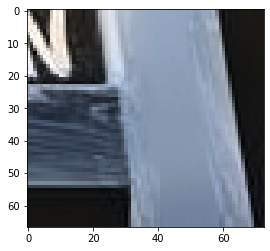

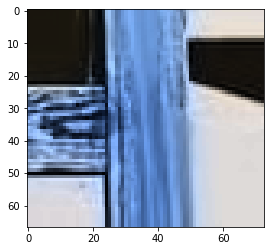

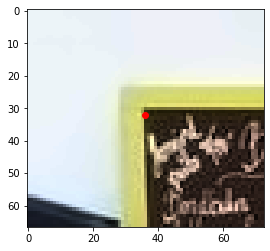

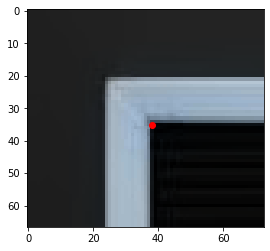

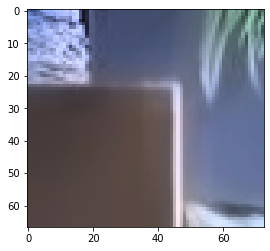

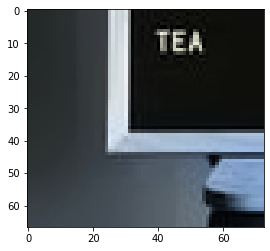

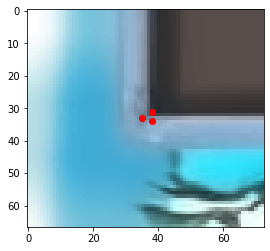

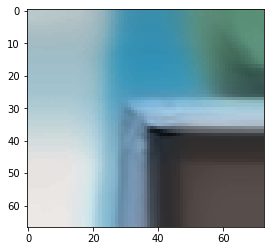

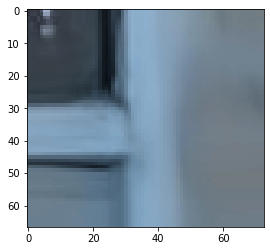

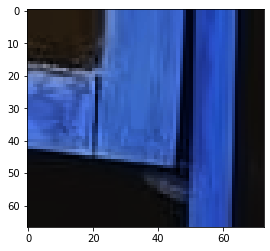

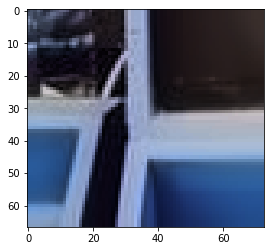

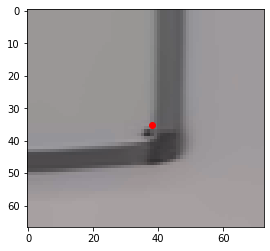

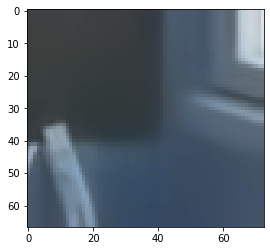

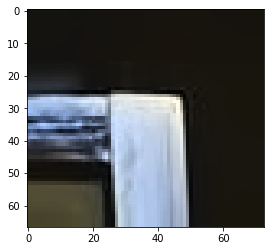

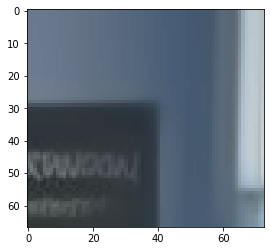

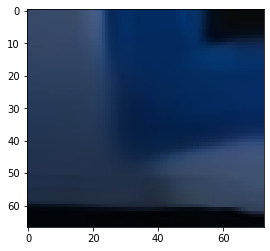

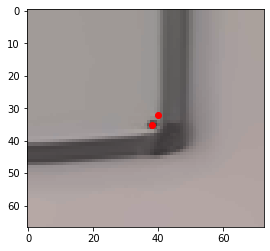

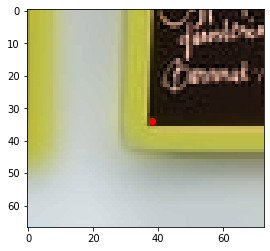

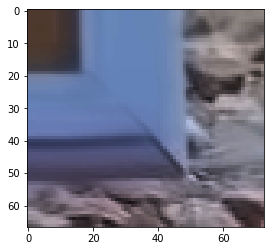

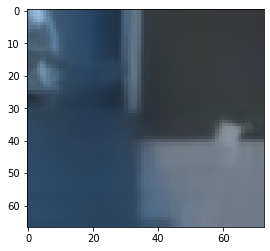

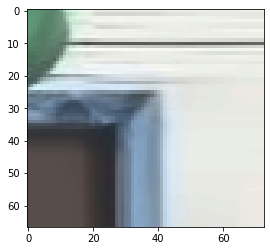

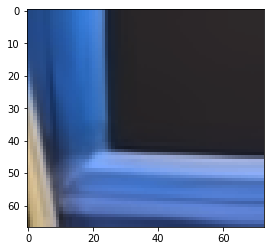

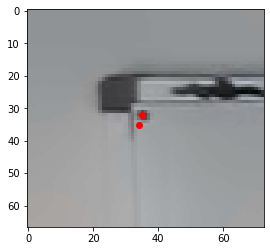

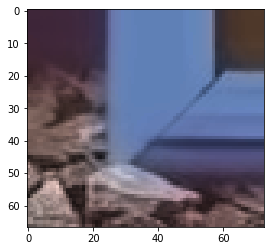

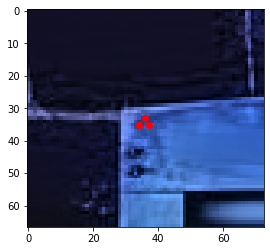

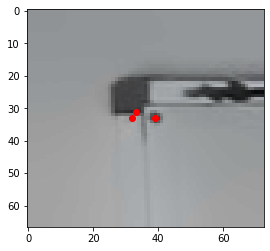

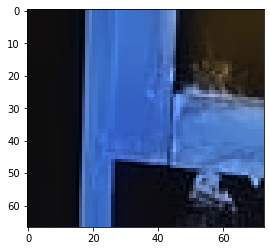

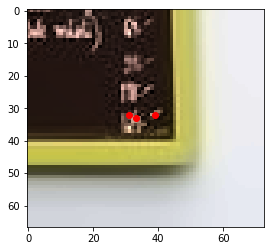

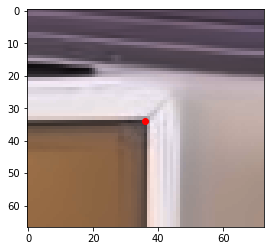

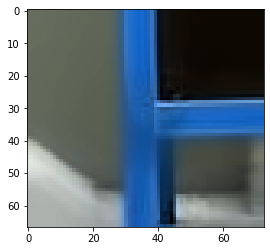

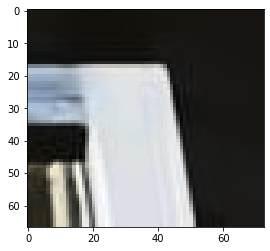

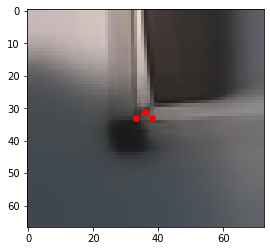

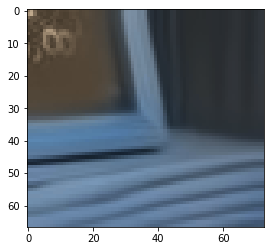

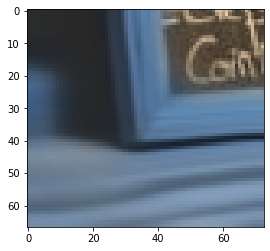

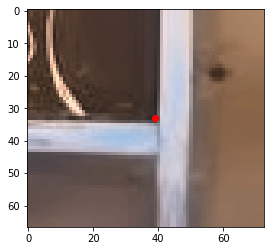

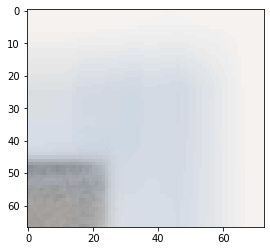

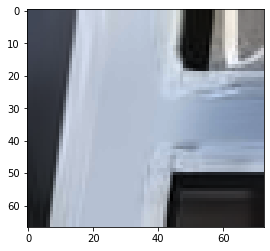

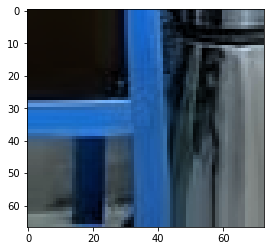

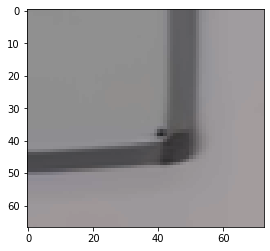

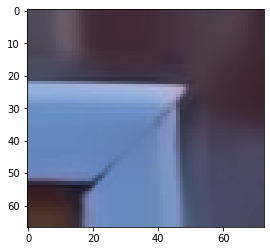

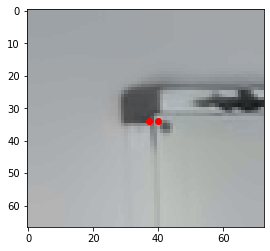

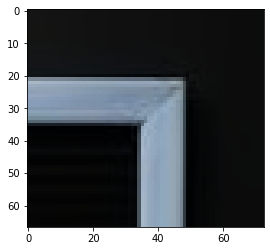

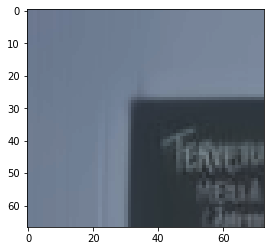

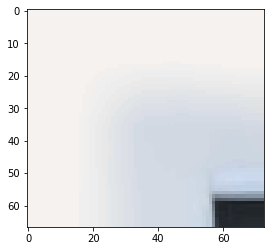

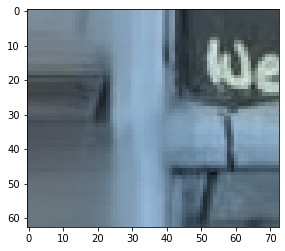

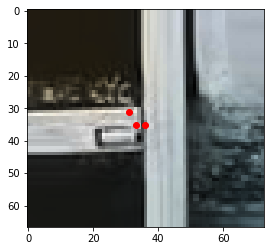

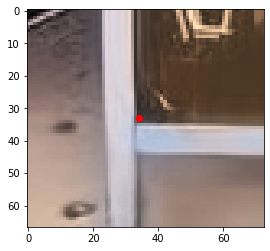

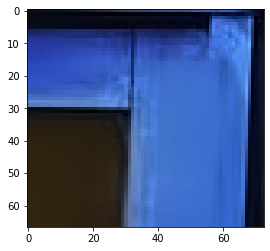

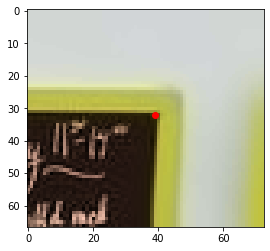

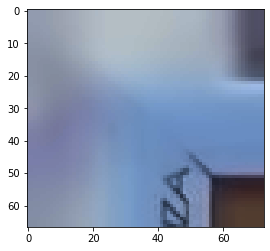

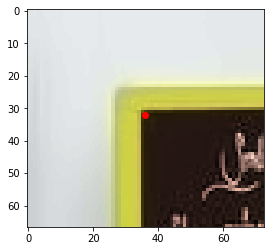

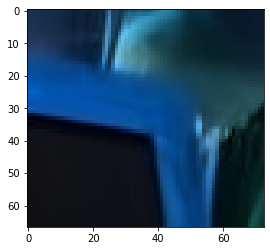

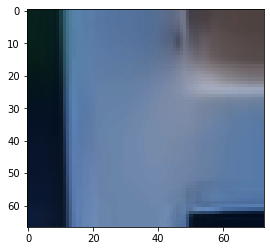

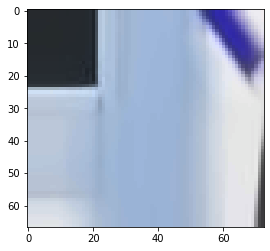

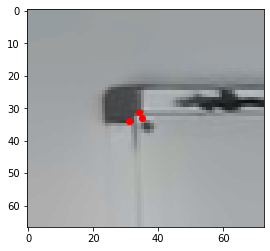

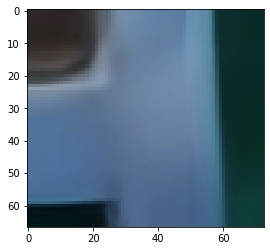

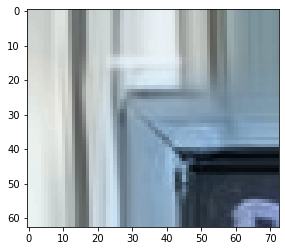

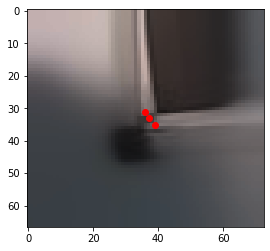

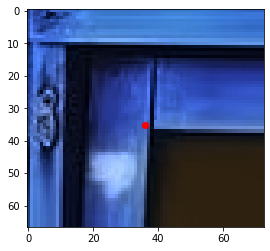

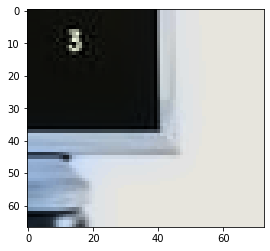

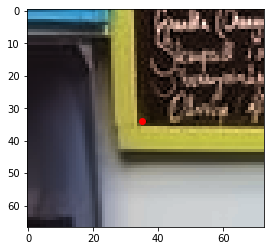

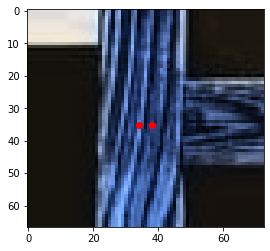

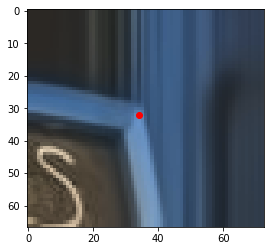

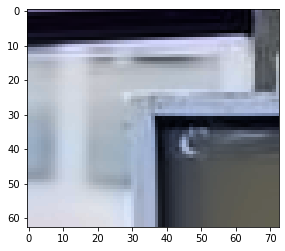

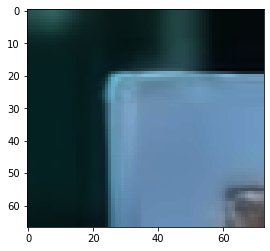

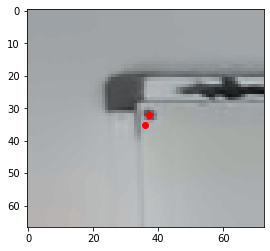

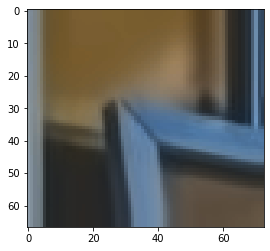

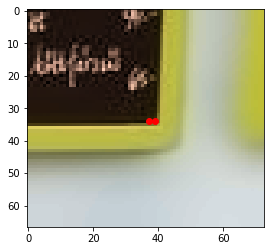

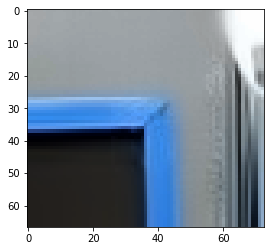

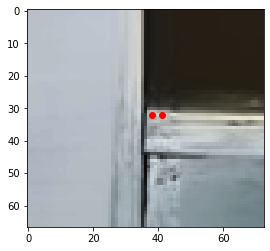

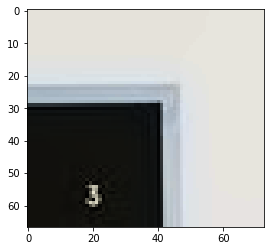

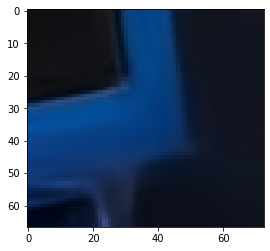

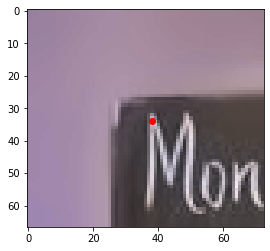

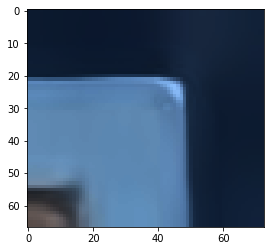

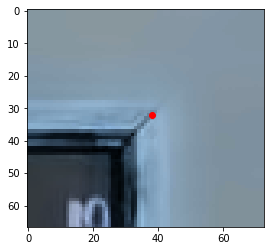

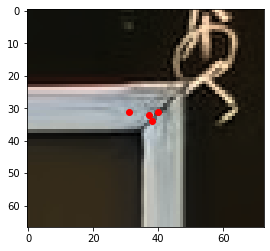

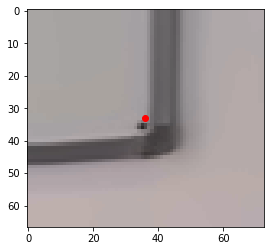

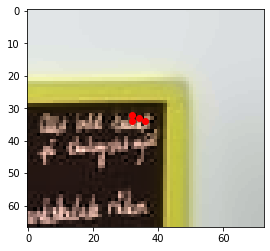

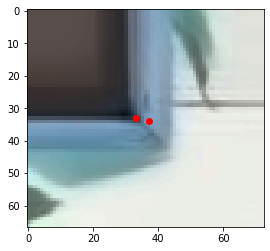

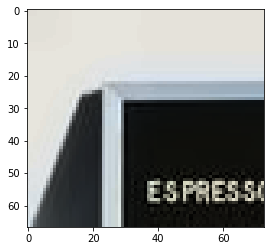

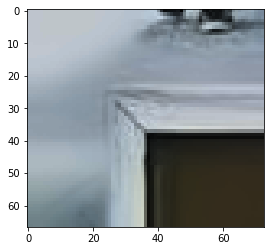

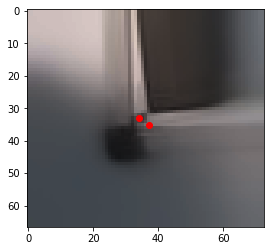

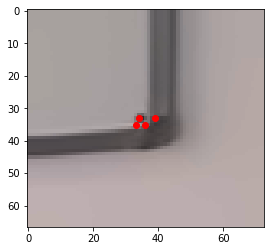

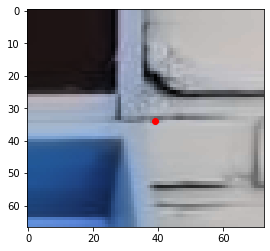

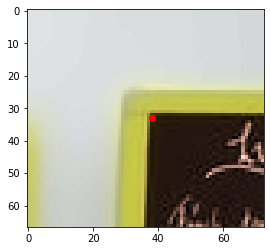

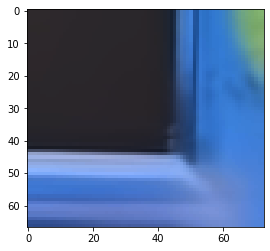

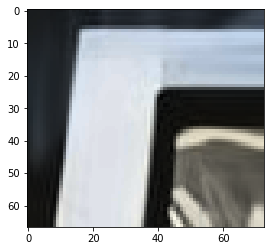

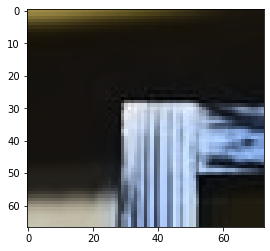

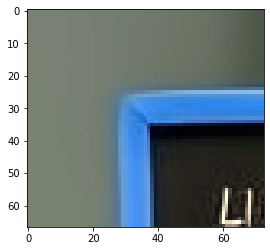

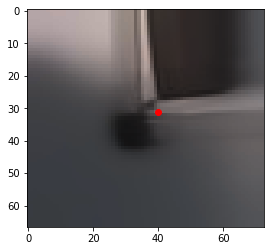

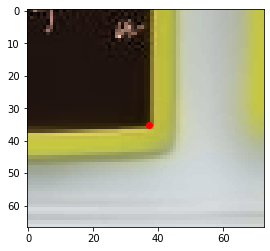

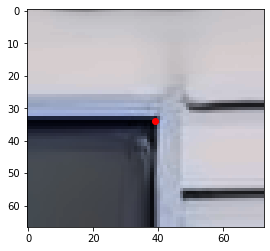

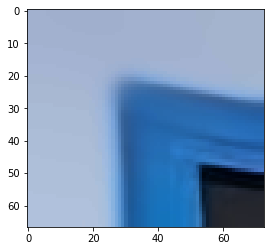

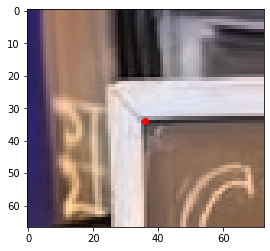

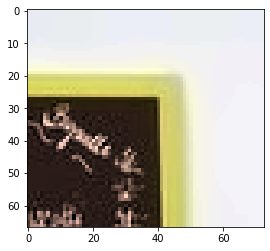

Entrenamiento completado


In [5]:
directory = os.fsencode(r'train')
contimg = 0
for entry in os.scandir(directory):
  estructura = []  # Estructura dada para almacenar keypoints de cada imagen
  ruta  = entry.path.decode("utf-8")
  img = cv.imread(ruta)
  dst = cv.fastNlMeansDenoisingColored(img,10,10,7,21)

  orb = cv.ORB_create() #n features el numero de keypoints nfeatures=2,scaleFactor=1.3,nlevels=2
  kp, des = orb.detectAndCompute(dst, None)
  descriptores.append(des) #funcion que almacena datos del keypoint en la lista
  h, w, z= dst.shape
  rellenarEstructura(kp,estructura)   #funcion que almacena datos del keypoint en la lista
  diccionario[contimg] = estructura
  contimg = contimg + 1
  
  plt.imshow(dst,cmap="gray")
  plt.show()
print("Entrenamiento completado")
flann.add(descriptores)


In [6]:
print(len(descriptores))

99


In [7]:
def enderezarHorizontal(imagen):
  gray = cv.cvtColor(imagen, cv.COLOR_BGR2GRAY)
  gray = cv.bitwise_not(gray)

  # Aplicarle un threshold para dejarla binaria
  # (los pixels serán 0 ó 255)
  binaria = cv.threshold(gray, 0, 255,
                  cv.THRESH_BINARY | cv.THRESH_OTSU)[1]


  # Usar la transformada de Hough para encontrar líneas
  # en la imagen binarizada, con una resolución de medio
  # grado (pi/720) y quedándose sólo con las líneas que
  # alcancen puntuación de 1000 o más (que serán las
  # más largas)
  lineas = cv.HoughLines(binaria, 1, np.pi/720, 1000)

  # Recopilemos qué ángulos ha encontrado la transformada
  # de hough para cada una de las líneas halladas
  angulos = []
  if isinstance(lineas, Iterable):
    for linea in lineas:
        theta = linea[0][1]
        angulos.append(theta)

    # Ahora contemos cuántas veces aparece cada ángulo
    from collections import Counter
    veces = Counter(angulos)

    # Y quedémonos con el ángulo que más veces se repite
    angulo = veces.most_common()[0][0]

    # Cambiar el sentido de la rotación si el ángulo es mayor de 180º
    if angulo > np.pi/2:
      angulo = -angulo

    # Ahora enderecemos la imagen, girando (en negativo) el ángulo detectado
    (h, w) = imagen.shape[:2]
    centro = (w // 2, h // 2)
    M = cv.getRotationMatrix2D(centro, angulo, 1.0)

    girada = cv.warpAffine(imagen, M, (w, h),
                  flags=cv.INTER_CUBIC, borderMode=cv.BORDER_REPLICATE)

    # Y volcamos a disco el resultado
    return girada

In [8]:
def centroPizarra(img,matriz):
  listx = []
  listy = []
  cont1 = 0
  y = matriz.max()

  for i in matriz:
      cont2 = 0
      for j in i:
          if (y == j):
              listx.append(cont1*10)
              listy.append(cont2*10)
          cont2 = cont2 + 1;
      cont1 = cont1 + 1

  sum_x = 0
  sum_y = 0

  for i in listx:
      sum_x = i + sum_x

  for i in listy:
      sum_y = i +sum_y

  img = cv.circle(img, (int(sum_x/len(listx)),int(sum_y/len(listy))), 20, (255, 0, 255), 2)

In [9]:
def rellenarMatrizAcumulacion(kp1,m,matriz,img1):
  p1x= kp1[m.queryIdx].pt[0]
  p1y = kp1[m.queryIdx].pt[1]
  sizeAc= kp1[m.queryIdx].size
  sizeDicc = diccionario[m.imgIdx][m.trainIdx][1]
  size = sizeAc / sizeDicc
  modulo = diccionario[m.imgIdx][m.trainIdx][3]
  angulo = diccionario[m.imgIdx][m.trainIdx][4] + diccionario[m.imgIdx][m.trainIdx][2] - kp1[m.queryIdx].angle
  cX = (modulo * math.cos(angulo)) * size
  cY = (modulo * math.sin(angulo)) * size
  x = int((p1x + cX) // 10)
  y = int((p1y + cY) // 10)
  if ((x >= 0) and (x < yImagen // 10) and (y >= 0) and (y < xImagen // 10)):
      matriz[x, y] = matriz[x, y] + 1
      plt.plot(x*10,y*10, marker="o", color="red")

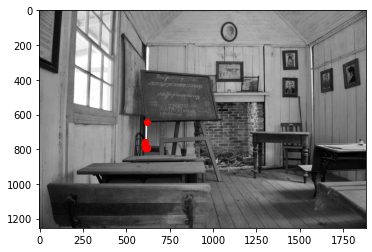

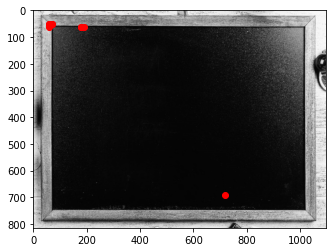

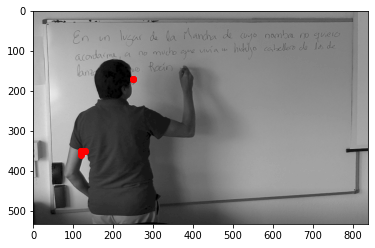

In [13]:
directory = os.fsencode(r'test')
for entry in os.scandir(directory):
  ruta = entry.path.decode("utf-8")
  img = cv.imread(ruta,0)

  xImagen, yImagen = img.shape

  orb = cv.ORB_create(nfeatures=4) #n features el numero de keypoints nfeatures=2,scaleFactor=1.3,nlevels=2
  kp1, des1 = orb.detectAndCompute(img, None)
  matches = flann.knnMatch(des1, k=6)
  matriz = np.zeros((yImagen // 10, xImagen // 10))

  for r in matches:
    for m in r:
      rellenarMatrizAcumulacion(kp1,m,matriz,img)

  plt.imshow(img,cmap="gray")
  plt.show()